# Vehicle detection

In [75]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.svm import LinearSVC
%matplotlib inline

## Manual vehicle detection

(<matplotlib.image.AxesImage at 0x7f547f1ca2b0>,
 <matplotlib.text.Text at 0x7f547038c588>)

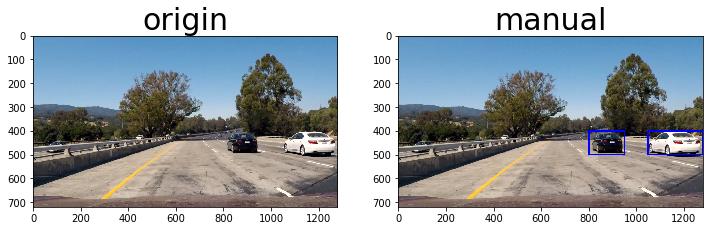

In [2]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    draw_img = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    return draw_img

image = mpimg.imread('test_images/1.jpg')
bboxes = [((800, 400), (950, 500)), ((1050, 400), (1280, 500))]
draw_img = draw_boxes(image, bboxes)

f, axs = plt.subplots(1, 2, figsize=(12, 9))
axs[0].imshow(image), axs[0].set_title('origin', fontsize=30)
axs[1].imshow(draw_img), axs[1].set_title('manual', fontsize=30)

## Template Matching

(<matplotlib.image.AxesImage at 0x7f54703fec18>,
 <matplotlib.text.Text at 0x7f54703e63c8>)

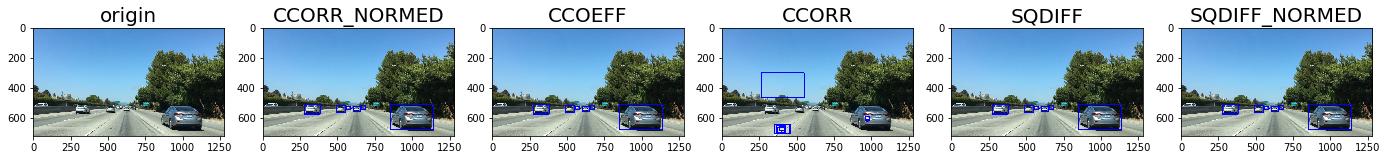

In [3]:
# method: cv2.TM_CCORR_NORMED, cv2.TM_CCOEFF, cv2.TM_CCORR, cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED
def find_matches(img, templates, method):
    bbox_list = []
    for template in templates:
        temp_img = mpimg.imread(template)
        match = cv2.matchTemplate(img, temp_img, method)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(match)
        w, h = (temp_img.shape[1], temp_img.shape[0])
        if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
            left_top = min_loc
        else:
            left_top = max_loc
        right_bottom = (left_top[0] + w, left_top[1] + h)
        bbox_list.append((left_top, right_bottom))
    return bbox_list

image = mpimg.imread('test_images/bbox-example-image.jpg')
templist = glob.glob('test_images/c*.jpg')
bboxes_CCORR_NORMED = find_matches(image, templist, cv2.TM_CCORR_NORMED)
result_CCORR_NORMED = draw_boxes(image, bboxes_CCORR_NORMED)
bboxes_CCOEFF = find_matches(image, templist, cv2.TM_CCOEFF)
result_CCOEFF = draw_boxes(image, bboxes_CCOEFF)
bboxes_CCORR = find_matches(image, templist, cv2.TM_CCORR)
result_CCORR = draw_boxes(image, bboxes_CCORR)
bboxes_SQDIFF = find_matches(image, templist, cv2.TM_SQDIFF)
result_SQDIFF = draw_boxes(image, bboxes_SQDIFF)
bboxes_SQDIFF_NORMED = find_matches(image, templist, cv2.TM_SQDIFF_NORMED)
result_SQDIFF_NORMED = draw_boxes(image, bboxes_SQDIFF_NORMED)

f, axs = plt.subplots(1, 6, figsize=(24, 9))
axs[0].imshow(image), axs[0].set_title('origin', fontsize=20)
axs[1].imshow(result_CCORR_NORMED), axs[1].set_title('CCORR_NORMED', fontsize=20)
axs[2].imshow(result_CCOEFF), axs[2].set_title('CCOEFF', fontsize=20)
axs[3].imshow(result_CCORR), axs[3].set_title('CCORR', fontsize=20)
axs[4].imshow(result_SQDIFF), axs[4].set_title('SQDIFF', fontsize=20)
axs[5].imshow(result_SQDIFF_NORMED), axs[5].set_title('SQDIFF_NORMED', fontsize=20)

## Color Histogram

(<Container object of 32 artists>, <matplotlib.text.Text at 0x7f546ac97400>)

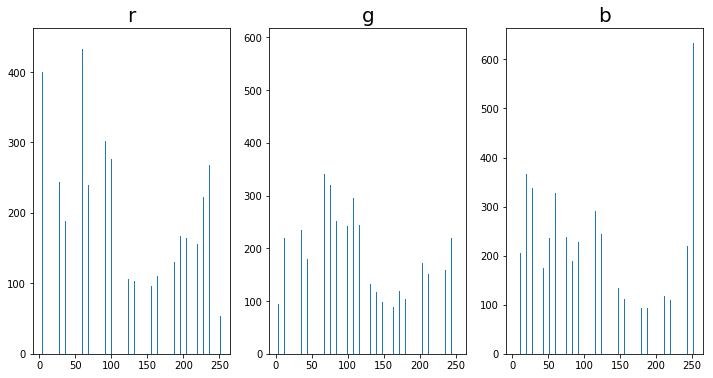

In [4]:
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # compute the histogram of the RGB channels separately
    rhist = np.histogram(image[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(image[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(image[:,:,2], bins=nbins, range=bins_range)
    
    # generate bin centers
    bin_edges = rhist[1]
    bin_centers = bin_edges[1:] - bins_range[1] / nbins / 2

    # concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    
    return rhist, ghist, bhist, bin_centers, hist_features
    
image = mpimg.imread('test_images/cutout1.jpg')
rhist, ghist, bhist, bin_centers, hist_features = color_hist(image)

f, axs = plt.subplots(1, 3, figsize=(12, 6))
axs[0].bar(bin_centers, rhist[0]), axs[0].set_title('r', fontsize=20)
axs[1].bar(bin_centers, ghist[0]), axs[1].set_title('g', fontsize=20)
axs[2].bar(bin_centers, bhist[0]), axs[2].set_title('b', fontsize=20)

## Spatial Binning of Color

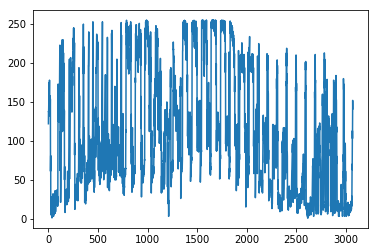

In [10]:
def bin_spatial(img, size=(32,32)):
    feature_vec = cv2.resize(img, size).ravel()
    return feature_vec

img = mpimg.imread('test_images/cutout1.jpg')
feature_vec = bin_spatial(img, size=(32,32))
plt.plot(feature_vec)

## Data Exploration

In [6]:
def data_look(car_list, notcar_list):
    data_dict = {}
    data_dict['n_cars'] = len(car_list)
    data_dict['n_notcars'] = len(notcar_list)
    image = mpimg.imread(car_list[0])
    data_dict['image_shape'] = image.shape
    data_dict['image_dtype'] = image.dtype
    return data_dict

cars = glob.glob('CarNotCar/Cars/*.jpeg')
notcars = glob.glob('CarNotCar/Notcars/*.jpeg')
data_info = data_look(cars, notcars)
print(data_info)

{'image_shape': (64, 64, 3), 'n_cars': 1196, 'image_dtype': dtype('uint8'), 'n_notcars': 1125}


In [87]:
color_space = 'RGB'
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0
spatial_size = (16,16)
hist_bins = 16
spatial_feat = True
hist_feat = True
hog_feat = True
y_start_stop = [None, None]

## HOG

(<matplotlib.image.AxesImage at 0x7f544a624dd8>,
 <matplotlib.text.Text at 0x7f544a620080>)

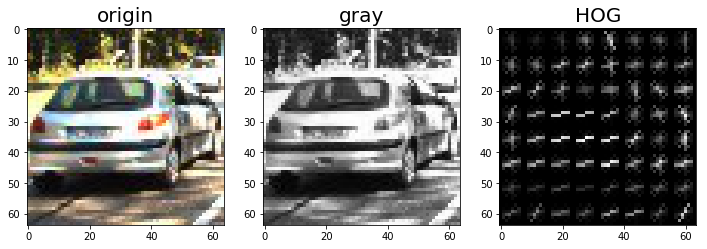

In [98]:
def HOG_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  visualise=True, feature_vector=feature_vec, block_norm='L2-Hys')
        return features, hog_image
    else:
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  visualise=False, feature_vector=feature_vec, block_norm='L2-Hys')
        return features
    

ind = np.random.randint(0, len(cars))
image = mpimg.imread(cars[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
features, hog_image = HOG_features(gray, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)

f, axs = plt.subplots(1, 3, figsize=(12, 6))
axs[0].imshow(image), axs[0].set_title('origin', fontsize=20)
axs[1].imshow(gray, cmap='gray'), axs[1].set_title('gray', fontsize=20)
axs[2].imshow(hog_image, cmap='gray'), axs[2].set_title('HOG', fontsize=20)

## Combine and Normalize Features

1196 1125


([<matplotlib.lines.Line2D at 0x7f544926f780>],
 <matplotlib.text.Text at 0x7f544865a898>)

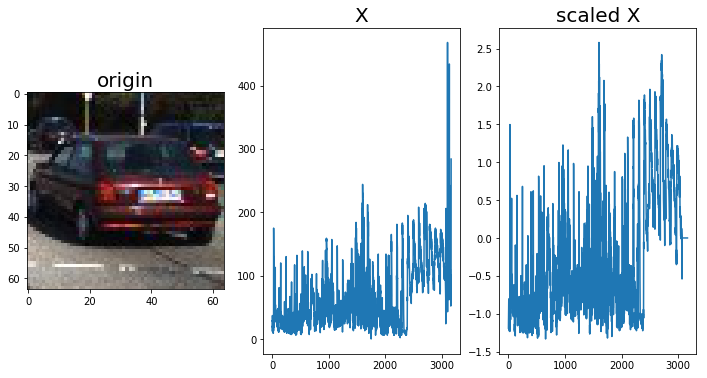

In [110]:
def extract_color_features(imgs, spatial_size=(32,32), hist_bins=32, hist_range=(0,256)):
    features = []
    for frame in imgs:
        img = mpimg.imread(frame)
        spat_features = bin_spatial(img, size=spatial_size)
        rhist, ghist, bhist, bin_centers, hist_features = color_hist(img, nbins=hist_bins, bins_range=hist_range)
        features.append(np.concatenate((spat_features, hist_features)))
    return features

car_features = extract_color_features(cars, spatial_size=(32,32), hist_bins=32, hist_range=(0,256))
notcar_features = extract_color_features(notcars, spatial_size=(32,32), hist_bins=32, hist_range=(0,256))
print(len(car_features), len(notcar_features))

y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
X = np.vstack((car_features, notcar_features)).astype(np.float64)
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)
car_ind = np.random.randint(0, len(cars))

f, axs = plt.subplots(1, 3, figsize=(12, 6))
axs[0].imshow(mpimg.imread(cars[car_ind])), axs[0].set_title('origin', fontsize=20)
axs[1].plot(X[car_ind]), axs[1].set_title('X', fontsize=20)
axs[2].plot(scaled_X[car_ind]), axs[2].set_title('scaled X', fontsize=20)

## Color Classify

In [31]:
and_state = np.random.randint(0, 100)
x_train, x_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

svc = LinearSVC()
svc.fit(x_train, y_train)
print(svc.score(x_test, y_test))

0.90752688172


## HOG Classify

In [108]:
def extract_HOG_features(imgs, orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0):
    features = []
    for frame in imgs:
        img = mpimg.imread(frame)
        if hog_channel=='all':
            hog_features = []
            for channel in range(img.shape[2]):
                hog_features.append(HOG_features(img[:,:,channel], orient, pix_per_cell,cell_per_block, vis=False, feature_vec=True))
        else:
            hog_features = HOG_features(img[:,:,hog_channel], orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        features.append(hog_features)
    return features

car_features = extract_HOG_features(cars, orient, pix_per_cell, cell_per_block, hog_channel)
notcar_features = extract_HOG_features(notcars, orient, pix_per_cell, cell_per_block, hog_channel)
print(len(car_features), len(notcar_features))

y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
X = np.vstack((car_features, notcar_features)).astype(np.float64)
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

rand_state = np.random.randint(0, 100)
x_train, x_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

svc = LinearSVC()
svc.fit(x_train, y_train)
print(svc.score(x_test, y_test))

1196 1125
0.903225806452


In [114]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

#         if spatial_feat == True:
#         spatial_features = bin_spatial(feature_image, size=spatial_size)
#         file_features.append(spatial_features)
# #         if hist_feat == True:
#             # Apply color_hist()
#         hist_features = color_hist(feature_image, nbins=hist_bins)
#         file_features.append(hist_features)
#         if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(HOG_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = HOG_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block)
        # Append the new feature vector to the features list
        file_features.append(hog_features)
        
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

cars = glob.glob('CarNotCar/Cars/*.jpeg')
notcars = glob.glob('CarNotCar/Notcars/*.jpeg')

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
print(len(car_features))
print(len(notcar_features))

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# # Fit a per-column scaler
# X_scaler = StandardScaler().fit(X)
# # Apply the scaler to X
# scaled_X = X_scaler.transform(X)

1196
1125


## Sliding Window

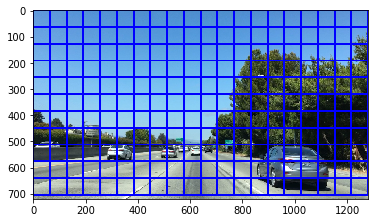

In [49]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # if x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
        
    # compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
        
    # compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0] * (1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1] * (1 - xy_overlap[1]))
    
    # compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0] * xy_overlap[0])
    ny_buffer = np.int(xy_window[1] * xy_overlap[1])
    nx_windows = np.int((xspan - nx_buffer) / nx_pix_per_step)
    ny_windows = np.int((yspan - ny_buffer) / ny_pix_per_step)
    
    window_list = []
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # calculate window position
            x_start = xs * nx_pix_per_step + x_start_stop[0]
            x_end = x_start + xy_window[0]
            y_start = ys * ny_pix_per_step + y_start_stop[0]
            y_end = y_start + xy_window[1]
            window_list.append(((x_start, y_start), (x_end, y_end)))
    return window_list

img = mpimg.imread('test_images/bbox-example-image.jpg')
windows = slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], xy_window=(128, 128), xy_overlap=(0.5, 0.5))
window_img = draw_boxes(img, windows, color=(0,0,255), thick=6)
plt.imshow(window_img)

## Search and Classify

In [83]:
# extract features for a single image
def single_img_features(img, color_space='RGB', spatial_size=(32,32), hist_bins=32, 
                        orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0, 
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    img_features=[]
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        if color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        if color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        if color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        if color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)
        
    if spatial_feat == True:
        spat_features = bin_spatial(feature_image, size=spatial_size)
        img_features.append(spat_features)
    
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        img_features.append(hist_features)
    
    if hog_feat == True:
        if hog_channel=='all':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(HOG_features(feature_image[:,:,channel], orient,
                                    pix_per_cell,cell_per_block, vis=False, feature_vec=True))
        else:
            hog_features = HOG_features(feature_image[:,:,hog_channel], orient, pix_per_cell,
                                        cell_per_block, vis=False, feature_vec=True)
        img_features.append(hog_features)
        
    return np.concatenate(img_features)

In [82]:
# search the given windows in the image
def search_windows(img, windows, clf, scaler, color_space='RGB', spatial_size=(32,32), 
                   hist_bins=32, hist_range=(0,256), orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0,
                   spatial_feat=True, hist_feat=True, hog_feat=True):
    on_windows = []
    for window in windows:
        # extract the test window from original window
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64,64))
        # extract features for that window using single_img_features
        features = single_img_features(test_img, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins, 
                                       orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                       hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
        # scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1,-1))
        # predict using classifier
        prediction = clf.predict(test_features)
        if prediction == 1:
            on_windows.append(window)
    
    return on_windows

In [92]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

rand_state = np.random.randint(0, 100)
x_train, x_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

svc = LinearSVC()
svc.fit(x_train, y_train)

ValueError: setting an array element with a sequence.

In [ ]:
img = mpimg.imread('test_images/bbox-example-image.jpg')
draw_image = np.copy(img)
windows = slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], xy_window=(96, 96), xy_overlap=(0.5, 0.5))
hot_windows = search_windows(img, windows, svc, X_scaler, color_space='RGB', spatial_size=(16,16), 
                   hist_bins=16, hist_range=(0,256), orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0,
                   spatial_feat=True, hist_feat=True, hog_feat=True)

window_img = draw_boxes(draw_image, hot_windows, color=(0,0,255), thick=6)